In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind, f_oneway, chi2_contingency

In [2]:
# Load Dataset
df = pd.read_csv('/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv')

In [3]:
# Add length feature
df['length'] = df['text'].apply(len)

# Splitting data into Train and Test
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
# Text Processing Function
def text_process(text):
    non_punc = [char for char in text if char not in string.punctuation]
    non_punc = ''.join(non_punc)
    return [word for word in non_punc.split() if word.lower() not in stopwords.words('english')]

In [5]:
# 1. Descriptive Statistics
mean_length = df['length'].mean()
median_length = df['length'].median()
mode_length = df['length'].mode()[0]

print(f'Mean Length: {mean_length}')
print(f'Median Length: {median_length}')
print(f'Mode Length: {mode_length}')

Mean Length: 1048.391993811642
Median Length: 540.0
Mode Length: 95


In [6]:
# 2. T-Test and F-Test (ANOVA)
group1 = df[df['label'] == 'spam']['length']
group2 = df[df['label'] == 'ham']['length']

t_stat, p_val_t = ttest_ind(group1, group2)
f_stat, p_val_f = f_oneway(group1, group2)

print(f'T-Test p-value: {p_val_t}')
print(f'F-Test p-value: {p_val_f}')

T-Test p-value: 1.4215920220522614e-07
F-Test p-value: 1.4215920220499117e-07


In [7]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['label'], df['length'])

# Perform the chi-square test
chi2_stat, p_val_chi2, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-Square Test p-value: {p_val_chi2}')


Chi-Square Test p-value: 4.640113751083642e-12


In [8]:
# 3. Model Implementation
models = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'MLPClassifier': MLPClassifier(max_iter=1000)
}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=text_process)),
        ('tf', TfidfTransformer()),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    print(f'\nClassification Report for {model_name}:')
    print(classification_report(y_test, predictions))
    print(f'Accuracy Score: {accuracy_score(y_test, predictions) * 100:.2f}%')


Classification Report for MultinomialNB:
              precision    recall  f1-score   support

         ham       0.90      1.00      0.95      1246
        spam       1.00      0.69      0.82       461

    accuracy                           0.92      1707
   macro avg       0.95      0.85      0.88      1707
weighted avg       0.93      0.92      0.91      1707

Accuracy Score: 91.74%

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1246
        spam       0.95      0.97      0.96       461

    accuracy                           0.98      1707
   macro avg       0.97      0.98      0.97      1707
weighted avg       0.98      0.98      0.98      1707

Accuracy Score: 98.01%

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

         ham       1.00      0.99      0.99      1246
        spam       0.97      0.99      0.98       4

In [9]:
# 4. Apply K-Means Clustering
vectorizer = CountVectorizer(analyzer=text_process).fit(X)
X_transformed = vectorizer.transform(X)
tfidf_transformer = TfidfTransformer().fit(X_transformed)
X_tfidf = tfidf_transformer.transform(X_transformed)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_tfidf)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

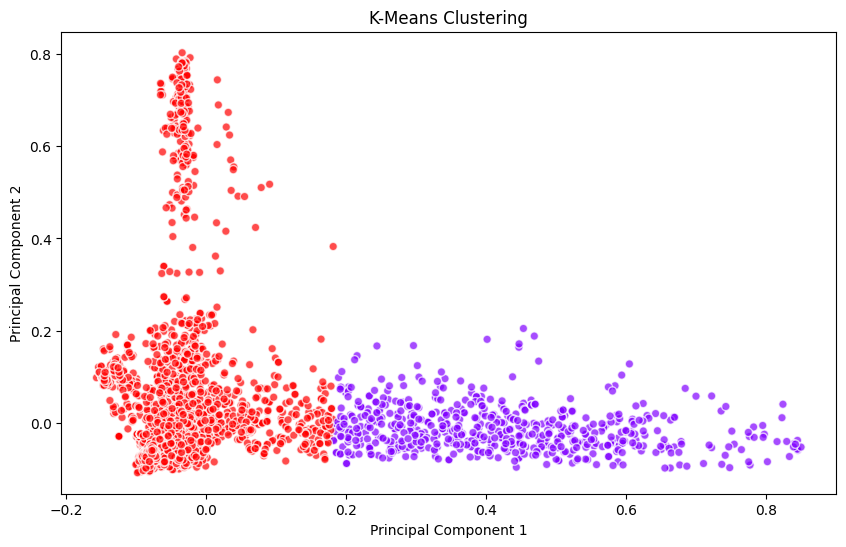

In [10]:
# 5. Visualize K-Means Clustering Results
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='rainbow', alpha=0.7, edgecolors='w')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

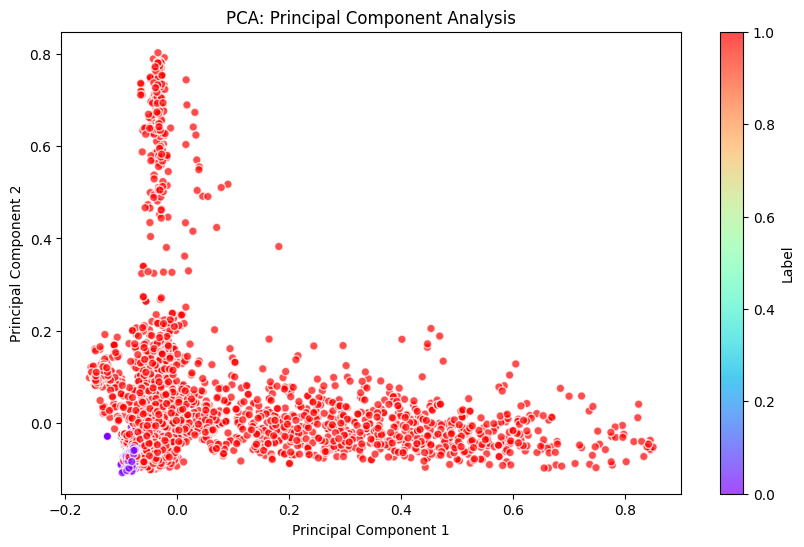

In [11]:
# 6. Perform PCA and Visualize
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.get_dummies(df['label']).iloc[:,0], cmap='rainbow', alpha=0.7, edgecolors='w')
plt.title('PCA: Principal Component Analysis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Label')
plt.show()

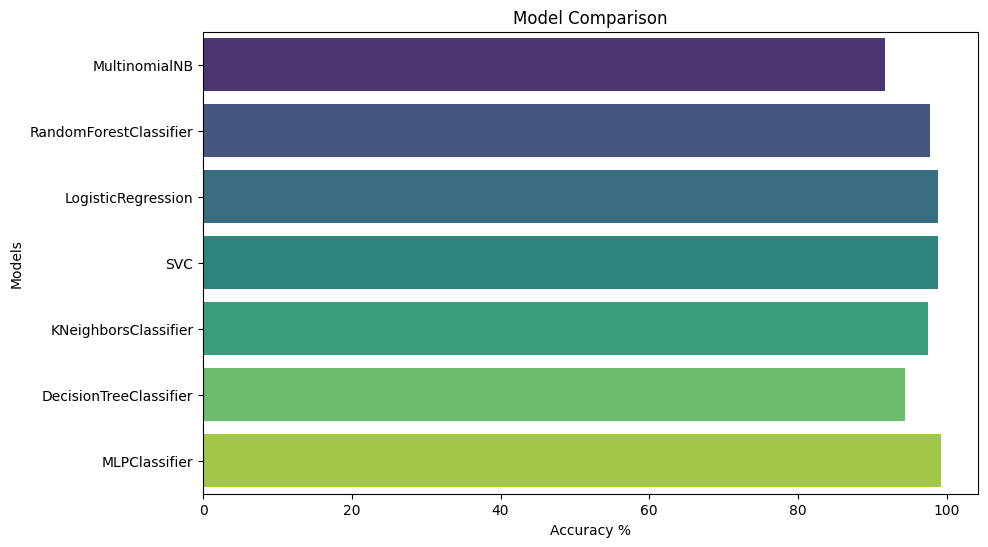

In [12]:
# 7. Model Comparison Visualization
model_names = []
accuracies = []

for model_name, model in models.items():
    pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=text_process)),
        ('tf', TfidfTransformer()),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions) * 100
    
    model_names.append(model_name)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=model_names, palette='viridis')
plt.xlabel('Accuracy %')
plt.ylabel('Models')
plt.title('Model Comparison')
plt.show()

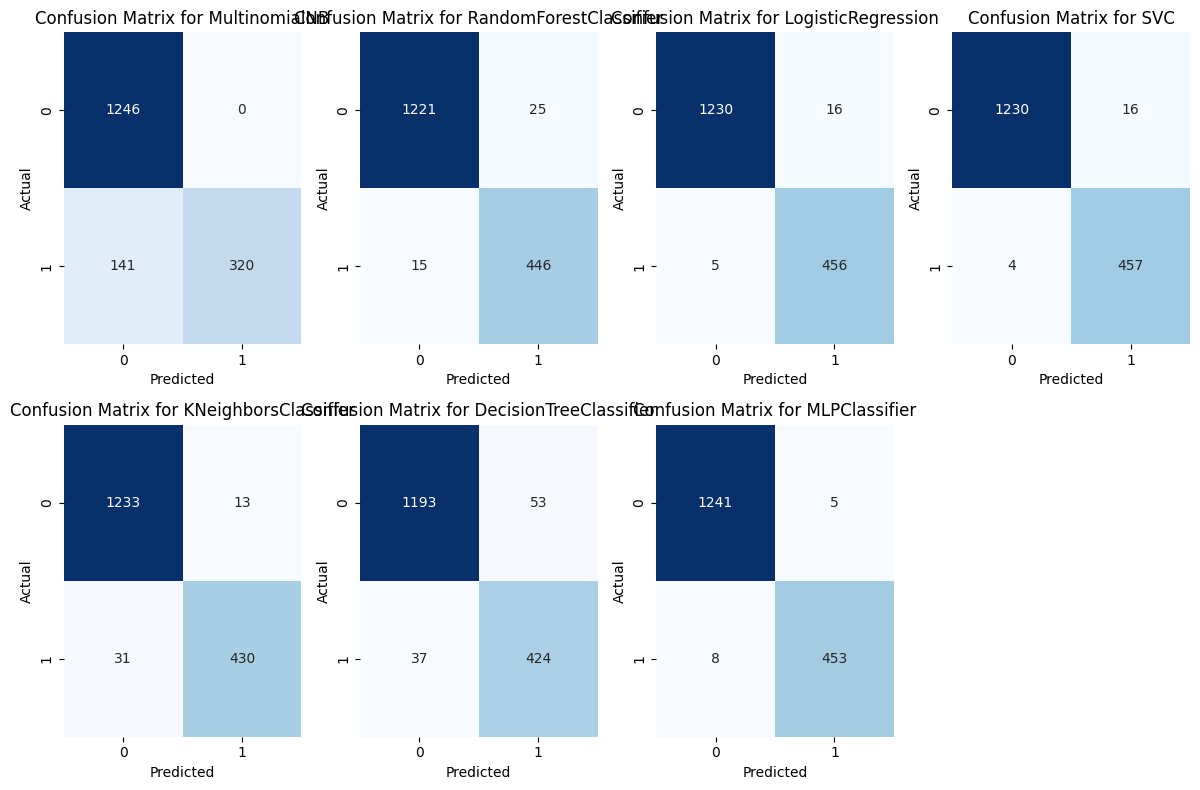

In [14]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  

# 8. Heat Map of Confusion Matrix
confusion_matrices = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=text_process)),
        ('tf', TfidfTransformer()),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    cm = confusion_matrix(y_test, predictions)  # Use the confusion_matrix function here
    confusion_matrices[model_name] = cm

plt.figure(figsize=(12, 8))
for model_name, cm in confusion_matrices.items():
    plt.subplot(2, 4, list(models.keys()).index(model_name) + 1)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [1]:
# 9. User Input Prediction
def predict_spam_or_not(message):
    best_model = LogisticRegression()  # Replace with the best model
    pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=text_process)),
        ('tf', TfidfTransformer()),
        ('classifier', best_model)
    ])
    
    # Fit the pipeline on the entire dataset
    pipeline.fit(X, y)
    
    # Make predictions on the user's message
    prediction = pipeline.predict([message])
    
    if prediction[0] == 'spam':
        return "This message is classified as SPAM."
    else:
        return "This message is NOT spam."

# Example user input
user_input = "Buy one iphone get 1 free"
result = predict_spam_or_not(user_input)
print(result)


NameError: name 'LogisticRegression' is not defined